In [20]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import time
DTYPE_FP64 = jnp.float64

# Generate dense A matrices
def generate_dense_A(key, hidden_dim, input_dim):
    return jax.random.normal(key, (input_dim, hidden_dim, hidden_dim), dtype=DTYPE_FP64) / jnp.sqrt(hidden_dim)

# Generate data paths with irregular sampling
def generate_paths(key, seq_len, d_omega):
    key1, key2 = jax.random.split(key)
    regular_times = jnp.linspace(0, 60, seq_len + 1)
    perturbations = jax.random.uniform(key1, (seq_len - 1,), minval=-0.03, maxval=0.03)
    irregular_times = jnp.sort(regular_times.at[1:-1].add(perturbations))
    dt_irregular = jnp.diff(irregular_times)
    dW = jax.random.normal(key2, (seq_len, d_omega), dtype=DTYPE_FP64) * jnp.sqrt(dt_irregular[:, None])
    omega_observed = jnp.vstack([jnp.zeros((1, d_omega), dtype=DTYPE_FP64), jnp.cumsum(dW, axis=0)])
    return irregular_times, omega_observed, dW

# Naive Padé with scaling and squaring
def pade_naive(A, b, theta):
    I = jnp.eye(A.shape[0], dtype=A.dtype)
    A_norm = jnp.linalg.norm(A, ord=1)
    s_f = jnp.maximum(0.0, jnp.ceil(jnp.log2(A_norm / theta)))
    s = int(float(s_f))
    A_scaled = A / (2.0 ** s)
    powers = [I]
    for k in range(1, len(b)):
        powers.append(powers[-1] @ A_scaled)
    p = sum(b[j] * powers[j] for j in range(len(b)))
    q = sum(b[j] * ((-1)**j) * powers[j] for j in range(len(b)))
    R = jnp.linalg.solve(q, p)
    for _ in range(s):
        R = R @ R
    return R, s

# Padé without scaling and squaring
def pade_no_scaling(A, b):
    I = jnp.eye(A.shape[0], dtype=A.dtype)
    powers = [I]
    for k in range(1, len(b)):
        powers.append(powers[-1] @ A)
    p = sum(b[j] * powers[j] for j in range(len(b)))
    q = sum(b[j] * ((-1)**j) * powers[j] for j in range(len(b)))
    R = jnp.linalg.solve(q, p)
    return R

# Padé functions with scaling and squaring
def pade_3(A):
    b = jnp.array([120, 60, 12, 1], dtype=A.dtype)
    theta_3 = 1
    return pade_naive(A, b, theta_3)

def pade_5(A):
    b = jnp.array([30240, 15120, 3360, 420, 30, 1], dtype=A.dtype)
    theta_5 = 1
    return pade_naive(A, b, theta_5)

def pade_7(A):
    b = jnp.array([17297280, 8648640, 1995840, 277200, 25200, 1512, 56, 1], dtype=A.dtype)
    theta_7 = 1
    return pade_naive(A, b, theta_7)

def pade_9(A):
    b = jnp.array([17643225600, 8821612800, 2075673600, 302702400, 30270240, 2162160, 110880, 3960, 90, 1], dtype=A.dtype)
    theta_9 = 1
    return pade_naive(A, b, theta_9)

def pade_13(A):
    b = jnp.array([
        64764752532480000, 32382376266240000, 7771770303897600,
        1187353796428800, 129060195264000, 10559470521600,
        670442572800, 33522128640, 1323241920,
        40840800, 960960, 16380,
        182, 1
    ], dtype=A.dtype)
    theta_13 = 1
    return pade_naive(A, b, theta_13)

# Taylor series
def expm_taylor(A, order=26):
    I = jnp.eye(A.shape[0], dtype=A.dtype)
    R = I
    term = I
    for k in range(1, order+1):
        term = (term @ A) / k
        R = R + term
    return R

# Linear CDE
class LinearCDE:
    def __init__(self, input_dim, hidden_dim, A_matrices):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.A_matrices = A_matrices

    @staticmethod
    def build_generators(A_matrices, delta_omega, g_scale=1):
        G_seq = jnp.einsum('ti,ijk->tjk', delta_omega, A_matrices)
        return g_scale * G_seq

    def expm_dense_batch_with_scaling(self, G_seq, method="pade", taylor_order=26, pade_type="13"):
        exp_seq = []
        scales = []
        for G in G_seq:
            if method=="pade":
                if pade_type=="3":
                    R, s = pade_3(G)
                elif pade_type=="5":
                    R, s = pade_5(G)
                elif pade_type=="7":
                    R, s = pade_7(G)
                elif pade_type=="9":
                    R, s = pade_9(G)
                elif pade_type=="13":
                    R, s = pade_13(G)
                else:
                    raise ValueError("Unknown Padé type")
                scales.append(s)
            elif method=="taylor":
                R = expm_taylor(G, order=taylor_order)
            else:
                raise ValueError("Unknown method")
            exp_seq.append(R)
        if method=="pade":
            return jnp.stack(exp_seq), jnp.array(scales, dtype=jnp.int32)
        else:
            return jnp.stack(exp_seq)

    def expm_dense_batch_no_scaling(self, G_seq, pade_type="13"):
        exp_seq = []
        for G in G_seq:
            if pade_type=="3":
                b = jnp.array([120, 60, 12, 1], dtype=G.dtype)
            elif pade_type=="5":
                b = jnp.array([30240, 15120, 3360, 420, 30, 1], dtype=G.dtype)
            elif pade_type=="7":
                b = jnp.array([17297280, 8648640, 1995840, 277200, 25200, 1512, 56, 1], dtype=G.dtype)
            elif pade_type=="9":
                b = jnp.array([17643225600, 8821612800, 2075673600, 302702400, 30270240, 2162160, 110880, 3960, 90, 1], dtype=G.dtype)
            elif pade_type=="13":
                b = jnp.array([
                    64764752532480000, 32382376266240000, 7771770303897600,
                    1187353796428800, 129060195264000, 10559470521600,
                    670442572800, 33522128640, 1323241920,
                    40840800, 960960, 16380,
                    182, 1
                ], dtype=G.dtype)
            else:
                raise ValueError("Unknown Padé type")
            R = pade_no_scaling(G, b)
            exp_seq.append(R)
        return jnp.stack(exp_seq)

    @staticmethod
    def cumulative_prod_scan(exp_seq):
        return jax.lax.associative_scan(lambda x, y: x @ y, exp_seq[::-1])

    def forward(self, delta_omega, h0, method="pade", taylor_order=26, g_scale=1, pade_type="13", use_scaling=True):
        G_seq = self.build_generators(self.A_matrices, delta_omega, g_scale=g_scale)
        if method=="pade":
            if use_scaling:
                exp_seq, scales = self.expm_dense_batch_with_scaling(G_seq, method=method, taylor_order=taylor_order, pade_type=pade_type)
                cumulative_products = self.cumulative_prod_scan(exp_seq)
                h_final = cumulative_products[-1] @ h0
                return h_final, scales
            else:
                exp_seq = self.expm_dense_batch_no_scaling(G_seq, pade_type=pade_type)
                cumulative_products = self.cumulative_prod_scan(exp_seq)
                h_final = cumulative_products[-1] @ h0
                return h_final
        elif method=="taylor":
            exp_seq = self.expm_dense_batch_with_scaling(G_seq, method=method, taylor_order=taylor_order)
            cumulative_products = self.cumulative_prod_scan(exp_seq)
            h_final = cumulative_products[-1] @ h0
            return h_final
        else:
            raise ValueError("Unknown method")

# Scipy expm
def scipy_method(A_matrices, delta_omega, h0, g_scale=1):
    from scipy.linalg import expm
    import numpy as np
    h = np.array(h0)
    for t in range(delta_omega.shape[0]):
        G_seq = g_scale * np.einsum('i,ijk->jk', np.array(delta_omega[t]), np.array(A_matrices))
        h = expm(G_seq) @ h
    return jnp.array(h)

# Euler method
def euler_method(A_matrices, delta_omega, h0, num_substeps=100000, g_scale=1):
    I = jnp.eye(h0.shape[0], dtype=h0.dtype)
    def step(h, dW):
        dW_sub = dW / num_substeps
        G_sub = g_scale * jnp.einsum('i,ijk->jk', dW_sub, A_matrices)
        def substep(h_inner, _):
            return (I + G_sub) @ h_inner, None
        h_final, _ = jax.lax.scan(substep, h, None, length=num_substeps)
        return h_final, None
    h_final, _ = jax.lax.scan(step, h0, delta_omega)
    return h_final

# RK4 method
def rk4_method(A_matrices, delta_omega, h0, num_substeps=100, g_scale=1):
    I = jnp.eye(h0.shape[0], dtype=h0.dtype)
    def step(h, dW):
        dW_sub = dW / num_substeps
        G_sub = g_scale * jnp.einsum('i,ijk->jk', dW_sub, A_matrices)
        def substep(h_inner, _):
            K1 = G_sub @ h_inner
            K2 = G_sub @ (h_inner + 0.5*K1)
            K3 = G_sub @ (h_inner + 0.5*K2)
            K4 = G_sub @ (h_inner + K3)
            return h_inner + (K1 + 2*K2 + 2*K3 + K4)/6.0, None
        h_final, _ = jax.lax.scan(substep, h, None, length=num_substeps)
        return h_final, None
    h_final, _ = jax.lax.scan(step, h0, delta_omega)
    return h_final

# Experiment
key = jax.random.PRNGKey(42)
input_dim = 32
hidden_dim = 32
seq_len = 10
d_omega = input_dim
g_scale = 1

# Initialization
A_mats = generate_dense_A(key, hidden_dim, input_dim)
t_vals, omega_vals, delta_omega = generate_paths(key, seq_len, d_omega)
h0 = jnp.ones(hidden_dim, dtype=DTYPE_FP64)
model = LinearCDE(input_dim, hidden_dim, A_mats)

methods = [
    ("Padé 3 with scaling", "3", True),
    ("Padé 5 with scaling", "5", True),
    ("Padé 7 with scaling", "7", True),
    ("Padé 9 with scaling", "9", True),
    ("Padé 13 with scaling", "13", True),
    ("Padé 3", "3", False),
    ("Padé 5", "5", False),
    ("Padé 7", "7", False),
    ("Padé 9", "9", False),
    ("Padé 13", "13", False),
    ("Scipy", None, None),
    ("Taylor 1", 1, None),
    ("Taylor 2", 2, None),
    ("Taylor 5", 5, None),
    ("Taylor 10", 10, None),
    ("Taylor 20", 20, None),
    ("Taylor 26", 26, None),
    ("Euler 10", 10, None),
    ("Euler 100", 100, None),
    ("RK4 10", 10, None),
    ("RK4 100", 100, None)
]

results = {}
for method_info in methods:
    if len(method_info) == 3:
        name, param, use_scaling = method_info
    else:
        name, param = method_info
        use_scaling = None

    t0 = time.time()
    if "Padé" in name:
        if use_scaling is not None:
            if use_scaling:
                h, scales = model.forward(delta_omega, h0, method="pade", pade_type=str(param), g_scale=g_scale, use_scaling=True)
            else:
                h = model.forward(delta_omega, h0, method="pade", pade_type=str(param), g_scale=g_scale, use_scaling=False)
        else:
            h, scales = model.forward(delta_omega, h0, method="pade", pade_type=str(param), g_scale=g_scale)
    elif "Taylor" in name:
        h = model.forward(delta_omega, h0, method="taylor", taylor_order=int(param), g_scale=g_scale)
    elif "Euler" in name:
        h = euler_method(A_mats, delta_omega, h0, num_substeps=param, g_scale=g_scale)
    elif "RK4" in name:
        h = rk4_method(A_mats, delta_omega, h0, num_substeps=param, g_scale=g_scale)
    elif name=="Scipy":
        h = scipy_method(A_mats, delta_omega, h0, g_scale=g_scale)
    results[name] = (h, time.time() - t0)

# Euler ground truth
t0 = time.time()
h_euler_gt = euler_method(A_mats, delta_omega, h0, num_substeps=100000, g_scale=g_scale)
time_euler_gt = time.time() - t0

G_seq = model.build_generators(A_mats, delta_omega, g_scale=g_scale)
G_norms = jnp.array([jnp.max(jnp.sum(jnp.abs(G), axis=0)) for G in G_seq])

#  Norms
print("\nNorms of generator matrices at each time step:")
for t, norm_val in enumerate(G_norms):
    print(f"t={t:3d}, ||G_t||_F = {norm_val:.6e}")

# Results
print(f"\n{'Method':<25} {'Time (s)':<12} {'Relative Error':<15}")
print("-"*55)
for name, (h, t_elapsed) in results.items():
    rel_err = float(jnp.linalg.norm(h - h_euler_gt)/jnp.linalg.norm(h_euler_gt))
    print(f"{name:<25} {t_elapsed:<12.6f} {rel_err:<15.6e}")
print(f"{'Euler ground truth':<25} {time_euler_gt:<12.6f} {'0.00e+00':<15}")


Norms of generator matrices at each time step:
t=  0, ||G_t||_F = 2.561048e+02

Method                    Time (s)     Relative Error 
-------------------------------------------------------
Padé 3 with scaling       0.159148     8.551349e-03   
Padé 5 with scaling       0.015023     8.551349e-03   
Padé 7 with scaling       0.013904     8.551349e-03   
Padé 9 with scaling       0.015214     8.551349e-03   
Padé 13 with scaling      0.019319     8.551349e-03   
Padé 3                    0.007483     1.000000e+00   
Padé 5                    0.009698     1.000000e+00   
Padé 7                    0.011672     1.000000e+00   
Padé 9                    0.013828     1.000000e+00   
Padé 13                   0.017540     1.000000e+00   
Scipy                     0.018618     8.551349e-03   
Taylor 1                  0.005766     1.000000e+00   
Taylor 2                  0.004336     1.000000e+00   
Taylor 5                  0.016415     1.000000e+00   
Taylor 10                 0.005901    

In [5]:
# GPU warmup
print("Performing GPU warmup")
key_warmup = jax.random.PRNGKey(0)
A_warmup = generate_dense_A(key_warmup, 32, 32)
t_warmup, omega_warmup, delta_warmup = generate_paths(key_warmup, 5, 32)
h0_warmup = jnp.ones(32, dtype=DTYPE_FP64)
model_warmup = LinearCDE(32, 32, A_warmup)
_ = model_warmup.forward(delta_warmup, h0_warmup, method="pade", pade_type="13")
_ = model_warmup.forward(delta_warmup, h0_warmup, method="taylor", taylor_order=10)
_ = euler_method(A_warmup, delta_warmup, h0_warmup, num_substeps=100)
print("GPU warmup completed.\n")

# Run experiments for all sequence lengths
seq_lengths = [5, 10, 20, 30, 60, 100]
num_runs = 10
all_seq_results = {}

methods = [
    ("S&S 3", "3", True),
    ("S&S 5", "5", True),
    ("S&S 7", "7", True),
    ("S&S 9", "9", True),
    ("S&S 13", "13", True),
    ("Padé 3", "3", False),
    ("Padé 5", "5", False),
    ("Padé 7", "7", False),
    ("Padé 9", "9", False),
    ("Padé 13", "13", False),
    ("Scipy", None, None),
    ("Taylor 1", 1, None),
    ("Taylor 2", 2, None),
    ("Taylor 5", 5, None),
    ("Taylor 10", 10, None),
    ("Taylor 20", 20, None),
    ("Taylor 26", 26, None),
    ("RK4 10", 10, None),
    ("RK4 100", 100, None),
    ("Euler 10", 10, None),
    ("Euler 100", 100, None)
]

for seq_len in seq_lengths:
    print(f"\n{'='*60}")
    print(f"SEQUENCE LENGTH: {seq_len}")
    print(f"{'='*60}")
    all_results = []
    all_norms = []
    print(f"Running {num_runs} experiments for sequence length {seq_len}...")
    for run_idx in range(num_runs):
        print(f"Run {run_idx + 1}/{num_runs}")

        # Generate data for this run
        key = jax.random.PRNGKey(42 + run_idx)
        input_dim = 32
        hidden_dim = 32
        d_omega = input_dim
        g_scale = 1

        key1, key2 = jax.random.split(key)
        A_mats = generate_dense_A(key1, hidden_dim, input_dim)
        t_vals, omega_vals, delta_omega = generate_paths(key2, seq_len, d_omega)
        h0 = jnp.ones(hidden_dim, dtype=DTYPE_FP64)
        model = LinearCDE(input_dim, hidden_dim, A_mats)

        # Run all methods
        results = {}
        for method_info in methods:
            if len(method_info) == 3:
                name, param, use_scaling = method_info
            else:
                name, param = method_info
                use_scaling = None

            t0 = time.time()
            if "Padé" in name or "S&S" in name:
                if use_scaling is not None:
                    if use_scaling:
                        h, scales = model.forward(delta_omega, h0, method="pade", pade_type=str(param), g_scale=g_scale, use_scaling=True)
                    else:
                        h = model.forward(delta_omega, h0, method="pade", pade_type=str(param), g_scale=g_scale, use_scaling=False)
                else:
                    h, scales = model.forward(delta_omega, h0, method="pade", pade_type=str(param), g_scale=g_scale)
            elif "Taylor" in name:
                h = model.forward(delta_omega, h0, method="taylor", taylor_order=int(param), g_scale=g_scale)
            elif "RK4" in name:
                h = rk4_method(A_mats, delta_omega, h0, num_substeps=param, g_scale=g_scale)
            elif "Euler" in name:
                h = euler_method(A_mats, delta_omega, h0, num_substeps=param, g_scale=g_scale)
            elif name=="Scipy":
                h = scipy_method(A_mats, delta_omega, h0, g_scale=g_scale)
            results[name] = (h, time.time() - t0)

        # Euler ground truth
        t0 = time.time()
        h_euler_gt = euler_method(A_mats, delta_omega, h0, num_substeps=100000, g_scale=g_scale)
        time_euler_gt = time.time() - t0

        # Generator matrix norms
        G_seq = model.build_generators(A_mats, delta_omega, g_scale=g_scale)
        G_norms = jnp.array([jnp.max(jnp.sum(jnp.abs(G), axis=0)) for G in G_seq])

        # Store results
        run_results = {}
        for name, (h, t_elapsed) in results.items():
            rel_err = float(jnp.linalg.norm(h - h_euler_gt)/jnp.linalg.norm(h_euler_gt))
            run_results[name] = {'time': t_elapsed, 'rel_error': rel_err}

        run_results['Euler ground truth'] = {'time': time_euler_gt, 'rel_error': 0.0}

        all_results.append(run_results)
        all_norms.append(G_norms)

    # Aggregate results
    method_names = list(all_results[0].keys())
    aggregated_results = {}

    for method in method_names:
        times = [run[method]['time'] for run in all_results]
        rel_errors = [run[method]['rel_error'] for run in all_results]
        aggregated_results[method] = {
            'time_mean': jnp.mean(jnp.array(times)),
            'time_std': jnp.std(jnp.array(times)),
            'rel_error_mean': jnp.mean(jnp.array(rel_errors)),
            'rel_error_std': jnp.std(jnp.array(rel_errors))
        }

    all_seq_results[seq_len] = aggregated_results

    # Generator matrix norms
    avg_norms = jnp.mean(jnp.array(all_norms), axis=0)
    std_norms = jnp.std(jnp.array(all_norms), axis=0)
    print(f"\nAverage norms of generator matrices at each time step (seq_len={seq_len}):")
    for t, (norm_mean, norm_std) in enumerate(zip(avg_norms, std_norms)):
        print(f"t={t:3d}, ||G_t||_F = {norm_mean:.6e} ± {norm_std:.6e}")

    # Results for this sequence length
    print(f"\n{'Method':<25} {'Time (s)':<20} {'Relative Error':<25}")
    print("-" * 70)
    for method in method_names:
        stats = aggregated_results[method]
        time_str = f"{stats['time_mean']:.6f} ± {stats['time_std']:.6f}"
        if stats['rel_error_mean'] == 0.0:
            error_str = "0.00e+00 ± 0.00e+00"
        else:
            error_str = f"{stats['rel_error_mean']:.2e} ± {stats['rel_error_std']:.2e}"
        print(f"{method:<25} {time_str:<20} {error_str:<25}")

# Summary
print(f"\n{'='*80}")
print("SUMMARY ACROSS ALL SEQUENCE LENGTHS")
print(f"{'='*80}")
print(f"\n{'Seq Len':<8} {'Method':<25} {'Time (s)':<20} {'Relative Error':<25}")
print("-" * 80)
for seq_len in seq_lengths:
    for method in method_names:
        stats = all_seq_results[seq_len][method]
        time_str = f"{stats['time_mean']:.6f} ± {stats['time_std']:.6f}"
        if stats['rel_error_mean'] == 0.0:
            error_str = "0.00e+00 ± 0.00e+00"
        else:
            error_str = f"{stats['rel_error_mean']:.2e} ± {stats['rel_error_std']:.2e}"
        print(f"{seq_len:<8} {method:<25} {time_str:<20} {error_str:<25}")
    print("-" * 80)

Performing GPU warmup
GPU warmup completed.


SEQUENCE LENGTH: 5
Running 10 experiments for sequence length 5...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10

Average norms of generator matrices at each time step (seq_len=5):
t=  0, ||G_t||_F = 1.218927e+02 ± 1.783952e+01
t=  1, ||G_t||_F = 1.068681e+02 ± 6.801567e+00
t=  2, ||G_t||_F = 1.120912e+02 ± 1.392207e+01
t=  3, ||G_t||_F = 1.146581e+02 ± 1.344975e+01
t=  4, ||G_t||_F = 1.117991e+02 ± 1.745008e+01

Method                    Time (s)             Relative Error           
----------------------------------------------------------------------
S&S 3                     0.044801 ± 0.005090  1.18e-02 ± 5.70e-03      
S&S 5                     0.054427 ± 0.005092  1.18e-02 ± 5.70e-03      
S&S 7                     0.063680 ± 0.006410  1.18e-02 ± 5.70e-03      
S&S 9                     0.072998 ± 0.004289  1.18e-02 ± 5.70e-03      
S&S 13                    0.095253 ± 0.004796  1.18e-02 

/tmp/ipython-input-1208950848.py:54: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "+-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(seq_lengths, taylor_1_times, '+-', label='Taylor 1', linewidth=2, linestyle='--', color='indigo')
/tmp/ipython-input-1208950848.py:55: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(seq_lengths, taylor_2_times, 'x-', label='Taylor 2', linewidth=2, linestyle='--', color='steelblue')
/tmp/ipython-input-1208950848.py:56: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "*-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(seq_lengths, taylor_5_times, '*-', label='Taylor 5', linewidth=2, linestyle='--', color='darkgreen')
/tmp/ipython-input-1208950848.py:57: UserWarning:

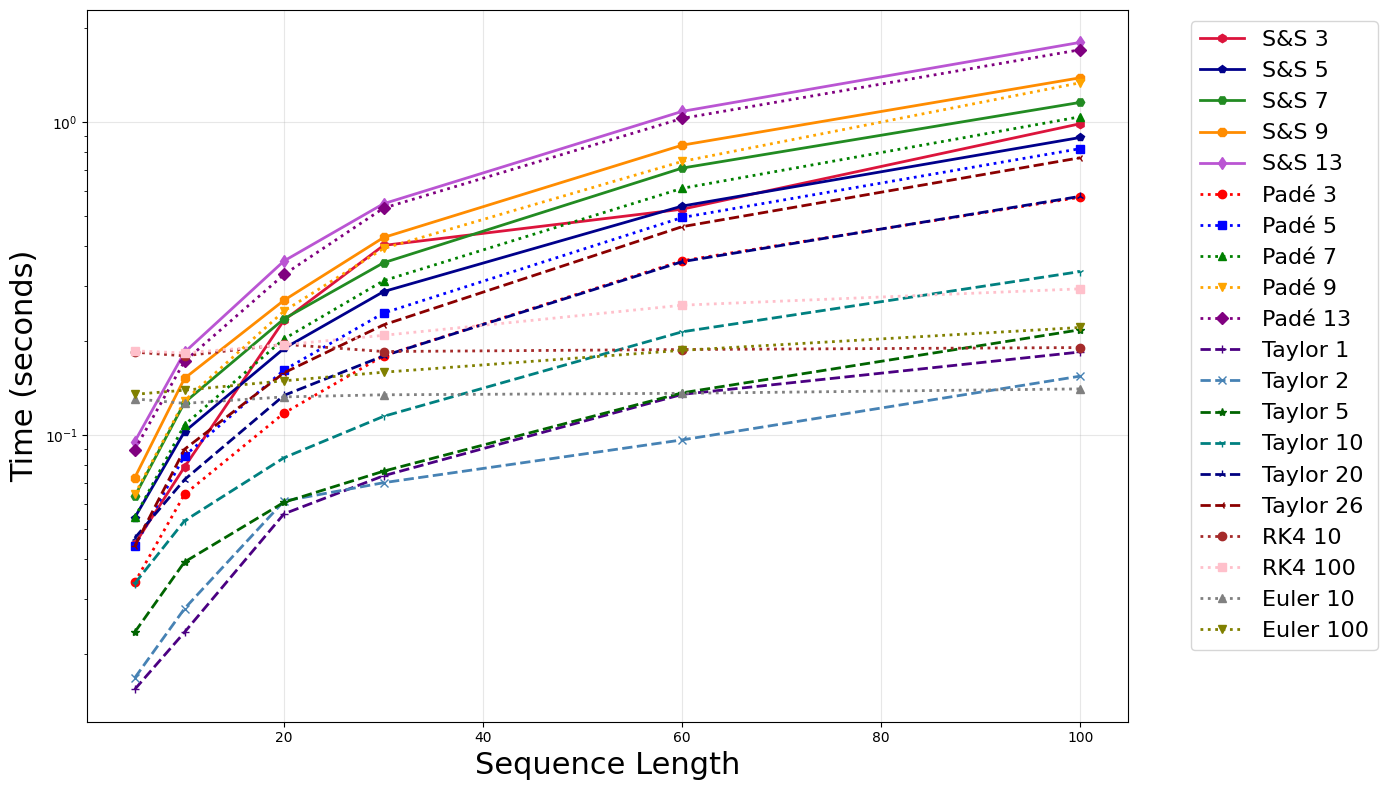

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Sequence lengths
seq_lengths = [5, 10, 20, 30, 60, 100]

# Padé Methods
pade_3_times = [0.033804, 0.064591, 0.117421, 0.179017, 0.360072, 0.574470]
pade_5_times = [0.044047, 0.085702, 0.161232, 0.245068, 0.494943, 0.821448]
pade_7_times = [0.054485, 0.107655, 0.202664, 0.310925, 0.613461, 1.038469]
pade_9_times = [0.064536, 0.128577, 0.248746, 0.394060, 0.747655, 1.333866]
pade_13_times = [0.089713, 0.171818, 0.325451, 0.530255, 1.025988, 1.700246]

# Taylor Methods
taylor_1_times = [0.015387, 0.023426, 0.055977, 0.074052, 0.134756, 0.184074]
taylor_2_times = [0.016741, 0.027869, 0.061486, 0.070363, 0.096404, 0.154106]
taylor_5_times = [0.023435, 0.039267, 0.060935, 0.076588, 0.136281, 0.216782]
taylor_10_times = [0.033520, 0.053152, 0.084548, 0.114646, 0.213488, 0.332609]
taylor_20_times = [0.046806, 0.071960, 0.133772, 0.178835, 0.357648, 0.578351]
taylor_26_times = [0.044135, 0.089974, 0.157922, 0.224672, 0.462685, 0.768178]

# S&S Methods
ss_3_times = [0.044801, 0.078986, 0.232545, 0.403022, 0.526061, 0.986881]
ss_5_times = [0.054427, 0.102407, 0.188938, 0.287004, 0.538382, 0.891618]
ss_7_times = [0.063680, 0.126920, 0.234897, 0.354806, 0.711889, 1.154275]
ss_9_times = [0.072998, 0.151587, 0.269277, 0.427283, 0.842640, 1.383378]
ss_13_times = [0.095253, 0.183618, 0.359598, 0.547772, 1.080365, 1.794898]

# Numerical Methods
rk4_10_times = [0.183811, 0.178886, 0.194713, 0.184651, 0.187405, 0.190127]
rk4_100_times = [0.185606, 0.182702, 0.194112, 0.208015, 0.259661, 0.292892]
euler_10_times = [0.130393, 0.126141, 0.132265, 0.134336, 0.135805, 0.140283]
euler_100_times = [0.134784, 0.138967, 0.148903, 0.158602, 0.186308, 0.220428]

# Plot
plt.figure(figsize=(14, 8))

plt.plot(seq_lengths, ss_3_times, 'h-', label='S&S 3', linewidth=2, color='crimson')
plt.plot(seq_lengths, ss_5_times, 'p-', label='S&S 5', linewidth=2, color='darkblue')
plt.plot(seq_lengths, ss_7_times, 'H-', label='S&S 7', linewidth=2, color='forestgreen')
plt.plot(seq_lengths, ss_9_times, '8-', label='S&S 9', linewidth=2, color='darkorange')
plt.plot(seq_lengths, ss_13_times, 'd-', label='S&S 13', linewidth=2, color='mediumorchid')
plt.plot(seq_lengths, pade_3_times, 'o:', label='Padé 3', linewidth=2, color='red')
plt.plot(seq_lengths, pade_5_times, 's:', label='Padé 5', linewidth=2, color='blue')
plt.plot(seq_lengths, pade_7_times, '^:', label='Padé 7', linewidth=2, color='green')
plt.plot(seq_lengths, pade_9_times, 'v:', label='Padé 9', linewidth=2, color='orange')
plt.plot(seq_lengths, pade_13_times, 'D:', label='Padé 13', linewidth=2, color='purple')
plt.plot(seq_lengths, taylor_1_times, '+-', label='Taylor 1', linewidth=2, linestyle='--', color='indigo')
plt.plot(seq_lengths, taylor_2_times, 'x-', label='Taylor 2', linewidth=2, linestyle='--', color='steelblue')
plt.plot(seq_lengths, taylor_5_times, '*-', label='Taylor 5', linewidth=2, linestyle='--', color='darkgreen')
plt.plot(seq_lengths, taylor_10_times, '1-', label='Taylor 10', linewidth=2, linestyle='--', color='teal')
plt.plot(seq_lengths, taylor_20_times, '2-', label='Taylor 20', linewidth=2, linestyle='--', color='navy')
plt.plot(seq_lengths, taylor_26_times, '3-', label='Taylor 26', linewidth=2, linestyle='--', color='darkred')
plt.plot(seq_lengths, rk4_10_times, 'o-', label='RK4 10', linewidth=2, linestyle=':', color='brown')
plt.plot(seq_lengths, rk4_100_times, 's-', label='RK4 100', linewidth=2, linestyle=':', color='pink')
plt.plot(seq_lengths, euler_10_times, '^-', label='Euler 10', linewidth=2, linestyle=':', color='gray')
plt.plot(seq_lengths, euler_100_times, 'v-', label='Euler 100', linewidth=2, linestyle=':', color='olive')

plt.xlabel('Sequence Length', fontsize=22)
plt.ylabel('Time (seconds)', fontsize=22)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
plt.yscale('log')
plt.tight_layout()
plt.show()

Warming up GPU
Warmup done.



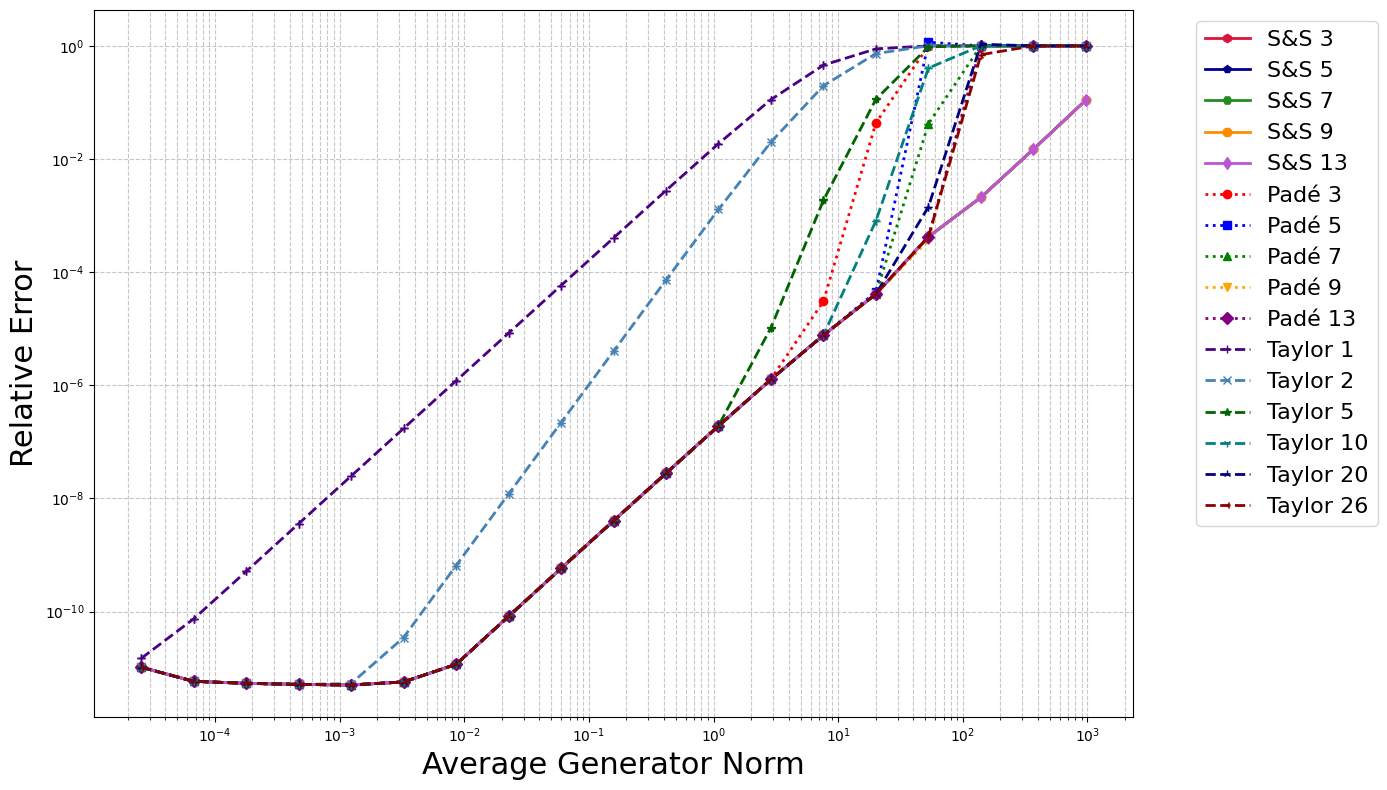

In [22]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

g_scales = jnp.logspace(-7, 1, 20)
num_trials = 10

# Methods
plot_methods = [
    "S&S 3", "S&S 5", "S&S 7", "S&S 9", "S&S 13",
    "Padé 3", "Padé 5", "Padé 7", "Padé 9", "Padé 13",
    "Taylor 1", "Taylor 2", "Taylor 5", "Taylor 10", "Taylor 20", "Taylor 26"
]

method_styles = {
    "S&S 3":    {'marker': 'h', 'linestyle': '-', 'color': 'crimson'},
    "S&S 5":    {'marker': 'p', 'linestyle': '-', 'color': 'darkblue'},
    "S&S 7":    {'marker': 'H', 'linestyle': '-', 'color': 'forestgreen'},
    "S&S 9":    {'marker': '8', 'linestyle': '-', 'color': 'darkorange'},
    "S&S 13":   {'marker': 'd', 'linestyle': '-', 'color': 'mediumorchid'},
    "Padé 3":   {'marker': 'o', 'linestyle': ':', 'color': 'red'},
    "Padé 5":   {'marker': 's', 'linestyle': ':', 'color': 'blue'},
    "Padé 7":   {'marker': '^', 'linestyle': ':', 'color': 'green'},
    "Padé 9":   {'marker': 'v', 'linestyle': ':', 'color': 'orange'},
    "Padé 13":  {'marker': 'D', 'linestyle': ':', 'color': 'purple'},
    "Taylor 1": {'marker': '+', 'linestyle': '--', 'color': 'indigo'},
    "Taylor 2": {'marker': 'x', 'linestyle': '--', 'color': 'steelblue'},
    "Taylor 5": {'marker': '*', 'linestyle': '--', 'color': 'darkgreen'},
    "Taylor 10":{'marker': '1', 'linestyle': '--', 'color': 'teal'},
    "Taylor 20":{'marker': '2', 'linestyle': '--', 'color': 'navy'},
    "Taylor 26":{'marker': '3', 'linestyle': '--', 'color': 'darkred'},
}

methods = [
    ("S&S", 3), ("S&S", 5), ("S&S", 7), ("S&S", 9), ("S&S", 13),
    ("Padé", 3), ("Padé", 5), ("Padé", 7), ("Padé", 9), ("Padé", 13),
    ("Taylor", 1), ("Taylor", 2), ("Taylor", 5), ("Taylor", 10), ("Taylor", 20), ("Taylor", 26)
]

# Warmup
print("Warming up GPU")
for g_scale in g_scales[:2]:
    G_seq = model.build_generators(A_mats, delta_omega, g_scale=g_scale)
    _ = euler_method(A_mats, delta_omega, h0, num_substeps=1000, g_scale=g_scale)
    for name, param in methods:
        method_key = f"{name} {param}"
        if method_key in plot_methods:
            if "S&S" in name:
                h, _ = model.forward(
                    delta_omega, h0, method="pade",
                    pade_type=str(param), g_scale=g_scale,
                    use_scaling=True
                )
            elif "Padé" in name:
                h = model.forward(
                    delta_omega, h0, method="pade",
                    pade_type=str(param), g_scale=g_scale,
                    use_scaling=False
                )
            elif "Taylor" in name:
                h = model.forward(
                    delta_omega, h0, method="taylor",
                    taylor_order=int(param), g_scale=g_scale
                )

print("Warmup done.\n")

# Results
avg_norms_mean, avg_norms_std = [], []
rel_errors_mean, rel_errors_std = [], []
for g_scale in g_scales:
    trial_norms = []
    trial_errors = []
    for _ in range(num_trials):

        # Average norm
        G_seq = model.build_generators(A_mats, delta_omega, g_scale=g_scale)
        avg_norm = jnp.mean(jnp.array([jnp.max(jnp.sum(jnp.abs(G), axis=0)) for G in G_seq]))
        trial_norms.append(float(avg_norm))

        # Relative errors
        rel_errs = []
        h_euler_gt = euler_method(A_mats, delta_omega, h0, num_substeps=100000, g_scale=g_scale)

        for name, param in methods:
            method_key = f"{name} {param}"
            if method_key not in plot_methods:
                continue

            if "S&S" in name:
                h, _ = model.forward(
                    delta_omega, h0, method="pade",
                    pade_type=str(param), g_scale=g_scale,
                    use_scaling=True
                )
            elif "Padé" in name:
                h = model.forward(
                    delta_omega, h0, method="pade",
                    pade_type=str(param), g_scale=g_scale,
                    use_scaling=False
                )
            elif "Taylor" in name:
                h = model.forward(
                    delta_omega, h0, method="taylor",
                    taylor_order=int(param), g_scale=g_scale
                )
            rel_err = float(jnp.linalg.norm(h - h_euler_gt) / jnp.linalg.norm(h_euler_gt))
            rel_errs.append(rel_err)
        trial_errors.append(rel_errs)


    # Average & Std
    avg_norms_mean.append(np.mean(trial_norms))
    avg_norms_std.append(np.std(trial_norms))
    rel_errors_mean.append(np.mean(trial_errors, axis=0))
    rel_errors_std.append(np.std(trial_errors, axis=0))
avg_norms_mean = np.array(avg_norms_mean)
avg_norms_std = np.array(avg_norms_std)
rel_errors_mean = np.array(rel_errors_mean)
rel_errors_std = np.array(rel_errors_std)

# Plot
plt.figure(figsize=(14, 8))
handles, labels = [], []
for i, method_name in enumerate(plot_methods):
    style = method_styles.get(method_name, {'marker':'o', 'linestyle':'-', 'color': None})
    eb = plt.errorbar(
        avg_norms_mean,
        rel_errors_mean[:, i],
        yerr=rel_errors_std[:, i],
        xerr=avg_norms_std,
        marker=style['marker'],
        linestyle=style['linestyle'],
        label=method_name,
        linewidth=2,
        color=style['color'],
        capsize=3)
    handles.append(eb[0])
    labels.append(method_name)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Average Generator Norm", fontsize=22)
plt.ylabel("Relative Error", fontsize=22)
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()


Sequence Length Comparison:
seq_len=20: 21 time points, avg Δt = 3.000
seq_len=60: 61 time points, avg Δt = 1.000
Resolution improvement: 3.0x finer


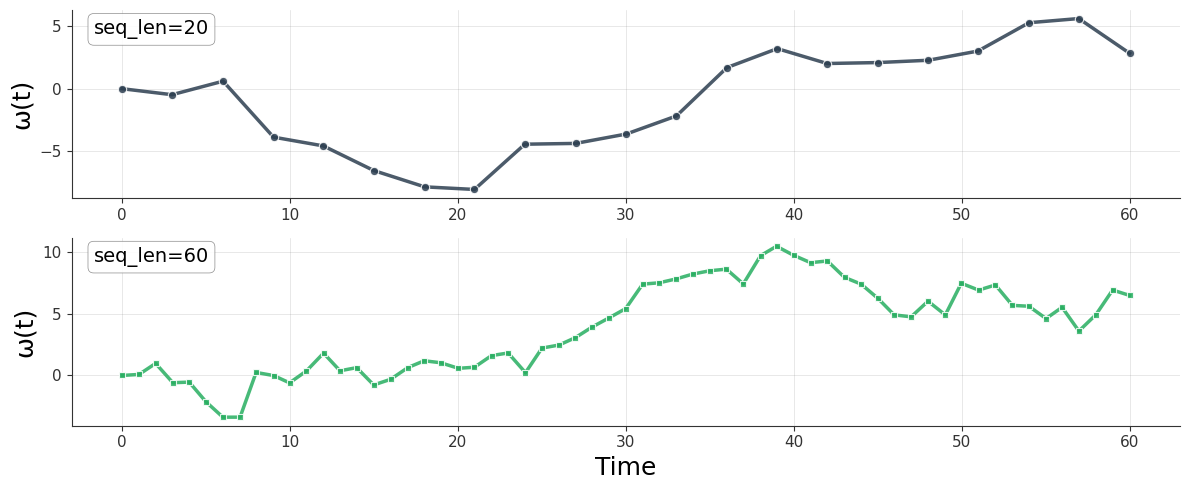

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
jax.config.update("jax_enable_x64", True)
DTYPE_FP64 = jnp.float64

def generate_paths(key, seq_len, d_omega):
    key1, key2 = jax.random.split(key)
    regular_times = jnp.linspace(0, 60, seq_len + 1)
    perturbations = jax.random.uniform(key1, (seq_len - 1,), minval=-0.03, maxval=0.03)
    irregular_times = jnp.sort(regular_times.at[1:-1].add(perturbations))
    dt_irregular = jnp.diff(irregular_times)
    dW = jax.random.normal(key2, (seq_len, d_omega), dtype=DTYPE_FP64) * jnp.sqrt(dt_irregular[:, None])
    omega_observed = jnp.vstack([jnp.zeros((1, d_omega), dtype=DTYPE_FP64), jnp.cumsum(dW, axis=0)])
    return irregular_times, omega_observed, dW

plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'serif']

# Generate data for two sequence lengths
key1 = jax.random.PRNGKey(43)
key2 = jax.random.PRNGKey(116)
d_omega = 1

# 20 step sequence
t_short, omega_short, dW_short = generate_paths(key1, 20, d_omega)
# 60 step sequence
t_long, omega_long, dW_long = generate_paths(key2, 60, d_omega)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5))
color1 = '#2C3E50'
color2 = '#27AE60'
ax1.plot(t_short, omega_short[:, 0], 'o-', color=color1, linewidth=2.5, markersize=6,
         alpha=0.85, markeredgecolor='white', markeredgewidth=0.8, zorder=3)
ax1.set_ylabel('ω(t)', fontsize=18)
ax1.text(0.02, 0.95, 'seq_len=20', transform=ax1.transAxes, fontsize=14, fontweight='normal',
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
         edgecolor='gray', alpha=0.9, linewidth=0.5))
ax1.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, color='gray')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('#333333')
ax1.spines['bottom'].set_color('#333333')
ax1.tick_params(axis='both', which='major', labelsize=11, colors='#333333')
ax2.plot(t_long, omega_long[:, 0], 's-', color=color2, linewidth=2.5, markersize=4,
         alpha=0.85, markeredgecolor='white', markeredgewidth=0.8, zorder=2)
ax2.set_xlabel('Time', fontsize=18)
ax2.set_ylabel('ω(t)', fontsize=18)
ax2.text(0.02, 0.95, 'seq_len=60', transform=ax2.transAxes, fontsize=14, fontweight='normal',
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
         edgecolor='gray', alpha=0.9, linewidth=0.5))
ax2.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, color='gray')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color('#333333')
ax2.spines['bottom'].set_color('#333333')
ax2.tick_params(axis='both', which='major', labelsize=11, colors='#333333')
plt.tight_layout()
plt.show()